## Welcome

This Colab notebook represents my captstone research project for C964 at WGU.

02/14/2023

Andrew Dahlstrom

To see the results, you must run the code blocks. This can be achieved by either clicking the arrow in the upper left of the code block or to run all the code blocks sequentially go to: Runtime Menu -> Run All

In this Colab notebook I build a Convolutional Neural Network model for the purpose of analyzing the text of customer reviews and predict the overall sentiment of the review. To test the model on a review you create Run All the code blocks and scroll down to the bottom to input your review to analyze.

Import relevant libraries

In [ ]:
import io
import os
import re
import shutil
import string
import random
import numpy as np
import pandas as pd
import tensorflow as tf

# Adjust the formatting of pandas dataframes and numpy arrays
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
np.set_printoptions(linewidth = 200)

# Download data from data repository and extract it
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip
!unzip drugsCom_raw.zip

--2023-02-15 05:10:03--  https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42989872 (41M) [application/x-httpd-php]
Saving to: ‘drugsCom_raw.zip’

drugsCom_raw.zip    100%[===================>]  41.00M  29.3MB/s    in 1.4s    

2023-02-15 05:10:05 (29.3 MB/s) - ‘drugsCom_raw.zip’ saved [42989872/42989872]

Archive:  drugsCom_raw.zip
  inflating: drugsComTest_raw.tsv    
  inflating: drugsComTrain_raw.tsv   


Load data into dataframes using Pandas database management tools.

In [ ]:
# Read training and testing data into pandas dataframes
df_train = pd.read_csv('drugsComTrain_raw.tsv', sep='\t')
df_test = pd.read_csv('drugsComTest_raw.tsv', sep='\t')

# Replace encoding of apostrophe with grammar apostrophe
df_train = df_train.replace(regex=['&#039;'], value="'")
df_test = df_test.replace(regex=['&#039;'], value="'")

# Shuffle training and testing set before splitting to ensure data is not clumped together
df_train = df_train.sample(frac=1, random_state=123).reset_index()
df_test = df_test.sample(frac=1, random_state=123).reset_index()

# Create a binary classification column for both sets based on rating. 0-5 stars = 0 (neg), 6 - 10 stars = 1 (pos)
df_train['label'] = [1 if int(i) > 5 else 0 for i in df_train['rating']]
df_test['label'] = [1 if int(i) > 5 else 0 for i in df_test['rating']]

# Remove irrelevant columns from both dataframes
df_train = df_train[['review', 'label']].copy()
df_test = df_test[['review', 'label']].copy()

# Due to limited virtual resources reduce data set size by half
df_train = df_train.iloc[:(int(df_train.shape[0]/2))]
df_test = df_test.iloc[:(int(df_test.shape[0]/2))]

Explore Data
First I will check for missing values and view the size of the training and test sets.

In [ ]:
# Display columns with missing values
print("Training set missing values per column:\n", df_train.isnull().sum(), "\n")
print("Testing set missing values per column:\n", df_test.isnull().sum(), "\n")
print("Total sample count for training set and mean:\n", df_train.count(), "\n Label Mean:", df_train['label'].mean(), "\n Mean length per review:", df_train['review'].str.len().mean(), "\n")
print("Total sample count for test set and mean\n", df_test.count(), "\n Label Mean:", df_test['label'].mean(), "\n Mean length per review:", df_test['review'].str.len().mean())


Training set missing values per column:
 review    0
label     0
dtype: int64 

Testing set missing values per column:
 review    0
label     0
dtype: int64 

Total sample count for training set and mean:
 review    80648
label     80648
dtype: int64 
 Label Mean: 0.7007241345104652 
 Mean length per review: 451.39760440432497 

Total sample count for test set and mean
 review    26883
label     26883
dtype: int64 
 Label Mean: 0.6974296023509281 
 Mean length per review: 449.78651936167836


There are no missing values. The label mean is skewed slightly more positive than .5 but the label mean for both the training and testing sets is approximately .7. The average sample length is also very similar between training and testing sets at approximately 450 characters. Next I will explore the distribution of review lengths and word frequencies in reviews.

In [ ]:
# Interactive distribution plot of review lengths
from matplotlib import pyplot as plt
from google.colab import output
output.enable_custom_widget_manager()
import ipywidgets as widgets
from ipywidgets import interact, interactive

Max_Length = 1000
def review_length(Max_Length):
    plt. hist([len(r) for r in df_train['review']], Max_Length)
    plt.xlim(0, Max_Length)
    plt.xlabel('Sample length in characters')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    fig = plt.gcf()
    fig_size = fig.get_size_inches()
    fig.set_size_inches(fig_size[0]*2, fig_size[1]*2, forward=True)
    plt.show()
interact(review_length, Max_Length=(0, 1000, 100));

interactive(children=(IntSlider(value=500, description='Max_Length', max=1000, step=100), Output()), _dom_clas…

From the histogram we can see that there is a spike that occurs around a sample size of 750 characters. Next I will explore word frequency distribution. In order to do so, the reviews must first be broken up unto word tokens known as ngrams.

In [ ]:
# I will use an sklearn tokenizer to split samples into ngram tokens which can be used to view the word frequency distribution
# A dictionary is returned where an ngram is a key and its elements are the count of the ngrams occuring at each index
from sklearn.feature_extraction.text import CountVectorizer

# Some words maybe typos or unusual. Only count words that appear in at least 10 reviews each
tokenizer = CountVectorizer(dtype='int32', strip_accents='unicode', decode_error='replace', analyzer='word', min_df=10)
tokenized_reviews = tokenizer.fit_transform(df_train['review'])
print("Number of unique words in reviews that occur in at least 10 reviews: ", tokenized_reviews.shape[1])

Number of unique words in reviews that occur in at least 10 reviews:  10214


In [ ]:
# Create list of ngrams in the index order from the complete vocabulary of the samples words
# This methology is adapted from Google's Tensorflow Text Classification tutorial:
# https://developers.google.com/machine-learning/guides/text-classification/step-2
all_ngrams = list(tokenizer.get_feature_names())

# Sum the counts per ngram
count_ngrams = tokenized_reviews.sum(axis=0).tolist()[0]
# Sort ngrams and counts by frequency
count_ngrams, all_ngrams = zip(*[(c, n) for c, n in sorted(zip(count_ngrams, all_ngrams), reverse=True)])
# Interactively pick the number of top frequency words you want to include in plot
min_ngrams = 50
max_ngrams = 100
num_ngrams = max_ngrams - min_ngrams
def user_ngrams(Min_Range, Max_Range):
    min_ngrams = Min_Range
    max_ngrams = Max_Range
    num_ngrams = Max_Range - Min_Range
    ngrams = list(all_ngrams)[min_ngrams:max_ngrams]
    counts = list(count_ngrams)[min_ngrams:max_ngrams]
    index = np.arange(num_ngrams)
    plt.bar(index, counts, width=.8, color='r')
    plt.xlabel('Vocabulary')
    plt.ylabel('Frequency')
    plt.title('Frequency distribution of words')
    plt.xticks(index, ngrams, rotation = 90)
    fig = plt.gcf()
    fig_size = fig.get_size_inches()
    fig.set_size_inches(fig_size[0]*4, fig_size[1]*2, forward=True)
    plt.show()
interact(user_ngrams, Min_Range=(0, 90, 10), Max_Range=(100, 200, 10));

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


interactive(children=(IntSlider(value=40, description='Min_Range', max=90, step=10), IntSlider(value=150, desc…

Below is an interactive table of the first 200 samples of training data. It can be filtered and queried to explore different types of reviews. To begin, click on the filter button in the upper right corner of the table.

In [ ]:
from google.colab import data_table
data_table.enable_dataframe_formatter()
data_table.DataTable(df_train.head(200), num_rows_per_page=20)

,review,label
0,"""I'm a great fan of diclofenac. I have severe...",1
1,"""I finished Epclusa 3 weeks ago. No virus show...",1
2,"""Have been taking this for almost 2 years now....",1
3,"""I was taking Opana ER 20 and was switched by ...",0
4,"""My experience with the DEPO shot was horrible...",0
...,...,...
195,"""ABSOULTELY AWFUL!!!! I was given this for dep...",0
196,"""I took Caduet which contains Lipitor for two ...",1
197,"""I was on Nuvaring for 3 months. As far as pos...",1
198,"""Hi! I am 18 years old . I was diagnosed with ...",1


Split Data: Next I will split the training data into a training set and a validation set. This will allow for testing the performance of the model without accidently overfitting it on the testing data which I will use to measure performance at the end.

In [ ]:
# Create a validation subset consisting of 20% of training data and a new training set consisting of the remaining 80% of the data.
df_val = df_train[:int(len(df_train.index)/5)]
df_train2 = df_train[int(len(df_train.index)/5):]

Now its time to transform the training text samples into numbers in order train the neural network model. I am using a Tensorflow tokenizer to create sequence vectors because word order matters in the customer reviews. This process is known as vectorization which will create an input for the embedding layer which is the first layer of the neural network.

In [ ]:
from tensorflow import keras
from statistics import mean
from tensorflow.keras.preprocessing import text
from tensorflow.keras.preprocessing import sequence

# Initialize Tensorflow tokenizer which has the following modified parameters:
# num_words = 10000, I selected this value because a shown earlier out total vocabulary for
# the review set it 13887 words that appear in at least 10 reviews.
# For simplicity I truncated this to an even 10000.
# Tokenize entire training set and keep the 10000 most frequent words
vectorizer = text.Tokenizer(num_words=10000)
vectorizer.fit_on_texts(df_train['review'])

# Vectorize training, validation and testing datasets
feature_train_vectors = vectorizer.texts_to_sequences(df_train2['review'])
feature_val_vectors = vectorizer.texts_to_sequences(df_val['review'])
feature_test_vectors = vectorizer.texts_to_sequences(df_test['review'])

# Output length of longest word sequence
MAX_SEQUENCE_LENGTH = max(len(x) for x in feature_train_vectors)
MEAN_SEQUENCE_LENGTH = mean(len(x) for x in feature_train_vectors)
print("Length of longest word sequence: ", MAX_SEQUENCE_LENGTH)
print("Length of mean word sequence: ", MEAN_SEQUENCE_LENGTH)
# Next we need all sequence lengths to be equal for accurate comparison
# so we can pad the beginning of the sequences to the max sequence length.
# In this case because there is such a variation between the max length and the mean length,
# I going to set max length closer to mean length to also accomodate for limited virtual resources.
# When I had the training length closer to the max length, the training process exceeded available RAM.
# The sequence vectors function as the input layer of a neural net.
MAX_SEQUENCE_LENGTH = int(MEAN_SEQUENCE_LENGTH * 1.5)
feature_train_vectors = sequence.pad_sequences(feature_train_vectors, maxlen=MAX_SEQUENCE_LENGTH)
feature_val_vectors = sequence.pad_sequences(feature_val_vectors, maxlen=MAX_SEQUENCE_LENGTH)
feature_test_vectors = sequence.pad_sequences(feature_test_vectors, maxlen=MAX_SEQUENCE_LENGTH)

Length of longest word sequence:  1874
Length of mean word sequence:  84.71106185774732


Build the Convolutional Neural Network (CNN) model on top of the embedding layer. The CNN model I will be using is a separable convolutional neural network which is a special version of a convolutional neural network with depthwise separable convolutions. This model was chosen because it is a sequence model meaning it utilizes word order information rather than just word count information. It was also recommended for text classification in a recent developers.google publication:
https://developers.google.com/machine-learning/guides/text-classification/step-4

Building a model also involves choosing a loss function, number of layers and an Activation function for the output layer of the network. The loss function chosen for this model is called binary cross-entropy. Why choose this particular loss function? Since there is two labels a binary loss function is appropriate. The cross-entropy component also known as logarithmic loss is used in binary problems to optimize the loss (discrepency between predicted vs actual label) on all observations it is trained on. The mathematical formula can be found in the following link:
https://en.wikipedia.org/wiki/Cross_entropy

In the output layer there are two labels negative and positive review sentiment, therefore I'm using a sigmoid activation function which will output a probability between 0-1 that the review should be labeld as negative.

In [ ]:
from tensorflow.python.keras import models
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers

from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import SeparableConv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D

cnn_model = models.Sequential()

# First add the embedding layer to model.
# input_dim is the vocabulary size from earlier (10000) + 1
# output_dim variable, from experimenting I found 100 to provide highest accuracy
# input_length is the max sequence length from earlier
cnn_model.add(Embedding(input_dim=10001, output_dim=50, input_length=MAX_SEQUENCE_LENGTH))

# Add layers of neural net
# This design was adapted from the developers.google
# text classification guide which can be found in the following link:
# https://developers.google.com/machine-learning/guides/text-classification/
# Initially I added a dropout rate layer which helps to prevent overfitting through regularization
# Next I added two sepCNN layers using the relu activation function which converts the
# input that node recieves to an output between 0-1.
# Next I added a layer of pooling which consolidates similar inputs
# Then i've added two more sepCNN layers with twice as mandy nodes to increase model complexity
# Another layer of pooling is added
# A final dropout layer is added
# The output layer is added which uses a sigmoid activation function. This is appropriate for
# binary classifications as it will yield a probability between 0-1 that the review is predicted
# to be negative sentiment.
cnn_model.add(Dropout(rate=.2))
cnn_model.add(SeparableConv1D(filters=64, kernel_size=3, activation='relu', bias_initializer='random_uniform', depthwise_initializer='random_uniform', padding='same'))
cnn_model.add(MaxPooling1D(pool_size=3))
cnn_model.add(SeparableConv1D(filters=128, kernel_size=3, activation='relu', bias_initializer='random_uniform', depthwise_initializer='random_uniform', padding='same'))
cnn_model.add(GlobalAveragePooling1D())
cnn_model.add(Dropout(rate=.2))
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 127, 50)           500050    
_________________________________________________________________
dropout (Dropout)            (None, 127, 50)           0         
_________________________________________________________________
separable_conv1d (SeparableC (None, 127, 64)           3414      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 42, 64)            0         
_________________________________________________________________
separable_conv1d_1 (Separabl (None, 42, 128)           8512      
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

There is an intermediary step required here to free up RAM in order to train the model. Due to limited resources I need do some garbage collection of data I no longer need.

In [ ]:
import gc
# Delete original unvectorized training and validation data sets.
os.remove('drugsComTrain_raw.tsv')
os.remove('drugsComTest_raw.tsv')
del tokenized_reviews
gc.collect()

415

The next step is to train the model on the training set and test it on the validation set. I am using an optimization function called Adam that will update the training weights based on the output of the loss function. Adam was  recommended for text classisification in the Google developers publication mentioned earlier. I will then check the accuracy of the predictions.

In [ ]:
# Compile model with learning parameters
# Through expirementation a learning rate of .001 was found provide the greatest accuracy
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# A new feature of keras called "EarlyStopping" allows testing on the validation set to stop prematurely if the model
# is not fitting the validation set well. This is very handy to prevent overfitting the model to the
# validation set while modifying parameters for optimization.
early_stopper = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]

# Train model on training set and test it on validation set
# Epochs represent the number of interations the entire data is used to train
# the model. Through expirementation I found 1000 to procude the optimal accuracy.
# Verbose 2 prints the epoch count as the model is training
# Batch size is the number of samples to look up per step in gradient descent typically
# the larger the training set your using the larger the batch size to reduce overall training
# time. I chose 1290 which is about 1% of the of the training data set per step.
results = cnn_model.fit(feature_train_vectors,
                        df_train2['label'],
                        epochs=10,
                        callbacks=early_stopper,
                        validation_data=(feature_val_vectors, df_val['label']),
                        verbose = 2,
                        batch_size=1000)

Epoch 1/10
65/65 - 28s - loss: 0.6458 - accuracy: 0.6882 - val_loss: 0.6142 - val_accuracy: 0.6961
Epoch 2/10
65/65 - 26s - loss: 0.6082 - accuracy: 0.7019 - val_loss: 0.6086 - val_accuracy: 0.6961
Epoch 3/10
65/65 - 27s - loss: 0.5706 - accuracy: 0.7046 - val_loss: 0.5097 - val_accuracy: 0.7648
Epoch 4/10
65/65 - 26s - loss: 0.4408 - accuracy: 0.8005 - val_loss: 0.4185 - val_accuracy: 0.8169
Epoch 5/10
65/65 - 26s - loss: 0.3805 - accuracy: 0.8354 - val_loss: 0.3997 - val_accuracy: 0.8315
Epoch 6/10
65/65 - 26s - loss: 0.3522 - accuracy: 0.8515 - val_loss: 0.3912 - val_accuracy: 0.8328
Epoch 7/10
65/65 - 30s - loss: 0.3297 - accuracy: 0.8626 - val_loss: 0.3904 - val_accuracy: 0.8350
Epoch 8/10
65/65 - 30s - loss: 0.3106 - accuracy: 0.8719 - val_loss: 0.3880 - val_accuracy: 0.8394
Epoch 9/10
65/65 - 26s - loss: 0.2929 - accuracy: 0.8806 - val_loss: 0.3923 - val_accuracy: 0.8407
Epoch 10/10
65/65 - 26s - loss: 0.2766 - accuracy: 0.8869 - val_loss: 0.3955 - val_accuracy: 0.8417


Next we can evaluate the model by viewing the results. The first figure shows loss summation per epoch for the model on the training set and the validation set. The loss should be decreasing to show the model is learning from the data to make better predictions and thus reducing loss. The second figure shows the change in accuracy per epoch on the training and validation sets. Ideally the model should become more accurate as the amount of data it trains on increases.

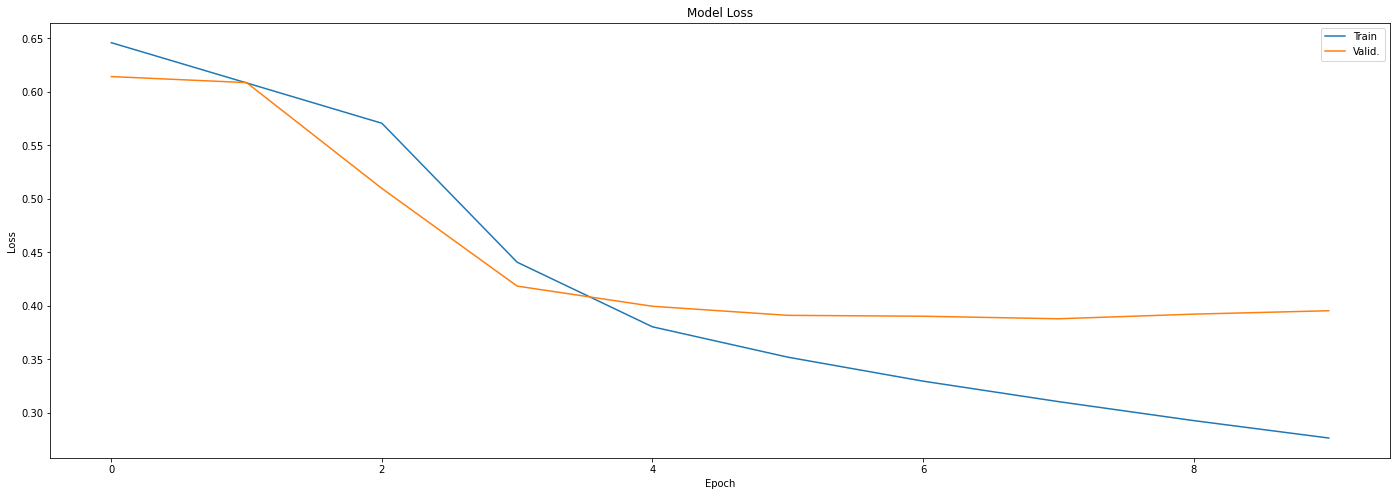

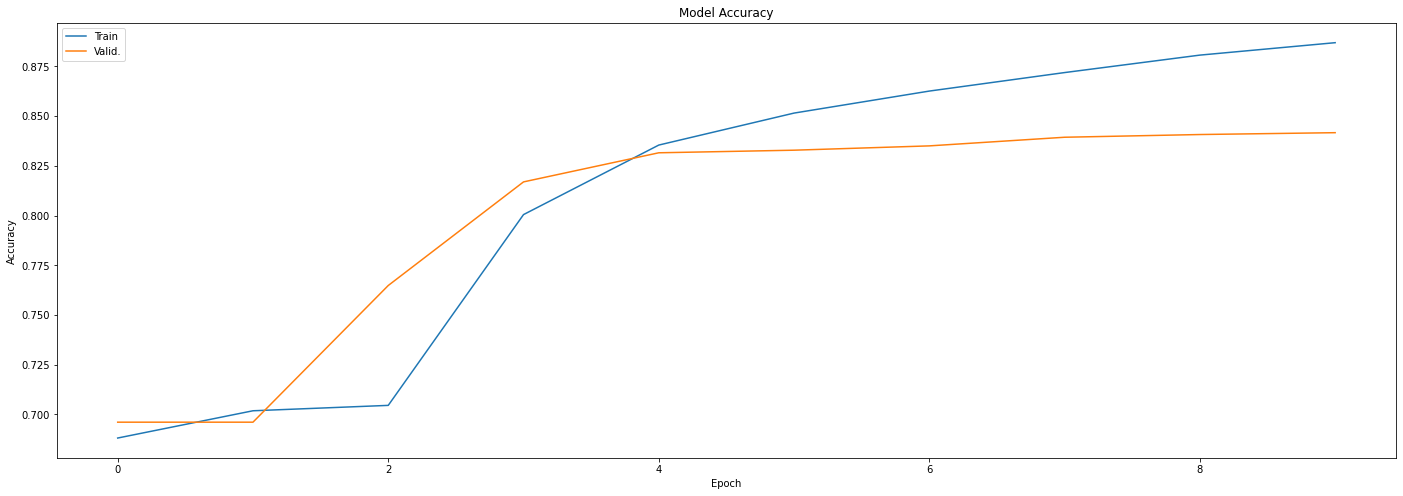

In [ ]:
# Display the loss summation per epoch for the model on the training
# set and the validation set.
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid.'], loc='upper right')
fig = plt.gcf()
fig_size = fig.get_size_inches()
fig.set_size_inches(fig_size[0]*4, fig_size[1]*2, forward=True)
plt.show()

# Display the accuracy of the model on the training and validation
# data sets.
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid.'], loc='upper left')
fig = plt.gcf()
fig_size = fig.get_size_inches()
fig.set_size_inches(fig_size[0]*4, fig_size[1]*2, forward=True)
plt.show()

The model appears to be a good fit. Now its time for the final test and evaluation on testing data.

In [ ]:
results_final = cnn_model.evaluate(feature_test_vectors, df_test['label'], batch_size=1000)
print("Final test loss = ", results_final[0], ", final test accuracy = ", results_final[1])

27/27 [==============================] - 3s 113ms/step - loss: 0.3924 - accuracy: 0.8424
Final test loss =  0.39242252707481384 , final test accuracy =  0.842353880405426


Below is an interactive tool to allow you to test out the model by entering a medication review and the model will attempt to predict the sentiment of your sample review. Run the code block and enter your sample review into the input box below and press the ENTER key.

In [ ]:
user_review = input('Enter a sample medication review: ')
review_vector = vectorizer.texts_to_sequences([user_review])
review_vector = sequence.pad_sequences(review_vector, maxlen=MAX_SEQUENCE_LENGTH)
predict_review = cnn_model.predict(review_vector)
if predict_review[0] > .5:
  print('\n This sample review is predicted to be POSITIVE sentiment.')
else:
  print('\n This sample review is predicted to be NEGATIVE sentiment.')

Enter a sample medication review: I have used xyz for a long time now and have not noticed any serious side effects. xyz has helped me a lot, I recommend it.

 This sample review is predicted to be POSITIVE sentiment.


Save a copy of the model as Tensorflow's SavedModel format by uncommenting the code and running the code block below.

In [ ]:
"""
!mkdir -p saved_model
cnn_model.save('saved_model/my_model')
"""